In [1]:
import numpy as np
from ticktack import fitting
import ticktack
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
mpl.style.use('seaborn-colorblind')

In [2]:
model = "Brehm21"
cbm = ticktack.load_presaved_model(model, production_rate_units='atoms/cm^2/s')
sf = fitting.SingleFitter(cbm, model, box="Troposphere", hemisphere='north')
sf.compile_production_model(model="flexible_sinusoid_affine_variant")

In [3]:
sf.box_idx

12

In [4]:
sf.time_data = np.arange(200, 230)
sf.d14c_data_error = np.ones((sf.time_data.size,))
sf.start = np.nanmin(sf.time_data)
sf.end = np.nanmax(sf.time_data)
sf.annual = np.arange(sf.start, sf.end + 1)
sf.oversample = 1008
sf.burn_in_time = np.arange(sf.start-2000, sf.start, 1.)
sf.time_data_fine = np.linspace(sf.start, sf.end + 2, (sf.annual.size + 1) * sf.oversample)
sf.offset = 0
sf.mask = np.in1d(sf.annual, sf.time_data)
sf.growth = sf.get_growth_vector("april-september")

In [5]:
sf.growth

DeviceArray([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float64)

In [6]:
params = np.array([-2.20263609e-03,  210,  2.55367316e-01,  3.28980240e+00,
        8.21112436e-01, -1.38787353e+00])

In [7]:
d14c = sf.dc14(params)

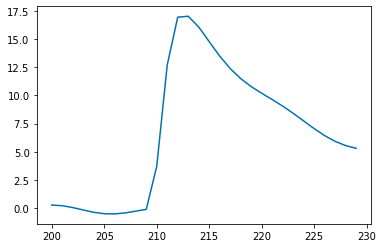

In [8]:
plt.plot(sf.time_data, d14c)

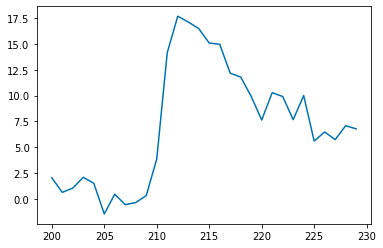

In [9]:
np.random.seed(0)
d14c_noise = d14c + np.random.randn(30)
plt.plot(sf.time_data, d14c_noise)

In [10]:
np.random.seed(0)
np.random.randn(30)

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
        0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
       -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
       -1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877])

In [11]:
d14c_noise

DeviceArray([ 2.04396167,  0.62494448,  1.03847238,  2.0828083 ,
              1.50744996, -1.4636355 ,  0.44654337, -0.56645162,
             -0.36293356,  0.31171516,  3.86117637, 14.15983599,
             17.69547948, 17.13889639, 16.50189051, 15.09707626,
             14.97834819, 12.17362511, 11.80156234,  9.92828078,
              7.63757439, 10.28804767,  9.91650337,  7.67323794,
             10.00532051,  5.60142961,  6.48028127,  5.73694013,
              7.0848602 ,  6.77983798], dtype=float64)

In [12]:
df = pd.DataFrame(d14c_noise)

filepath = 'north.csv'
df.to_csv(filepath, index=False)

In [13]:
model = "Brehm21"
cbm_recover = ticktack.load_presaved_model(model, production_rate_units='atoms/cm^2/s')
sf_recover = fitting.SingleFitter(cbm_recover, model, box="Troposphere", hemisphere="north")
sf_recover.load_data("recover_NH.csv", oversample=1008, burnin_time=2000)
sf_recover.compile_production_model(model="flexible_sinusoid_affine_variant")

In [14]:
sf.box_idx, sf.growth

(12,
 DeviceArray([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float64))

In [15]:
default_params = jnp.array([-1.00797052e-03,  2.10523473e+02, -3.35300358e-01,  3.85064256e+00,
        7.87839120e-01, -1.61086280e+00])
default_low_bounds = jnp.array([-1.76 * 0.05 / 5, 210 - 5, np.log10(4 / 52.), 0, -2, -2])
default_up_bounds = jnp.array([1.76 * 0.05 / 5, 210 + 5, np.log10(5.), 11, 1.5, 1.5])

In [16]:
chain = sf_recover.MarkovChainSampler(params,
                                          likelihood=sf_recover.log_joint_likelihood,
                                          burnin=1000,
                                          production=1000,
                                          args=(default_low_bounds, default_up_bounds))

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:17<00:00,  2.65it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


In [17]:
np.mean(chain, axis=0)

array([-3.05104542e-03,  2.10308901e+02, -1.32375293e-01,  2.80155308e+00,
        7.87050779e-01, -1.49165333e+00])

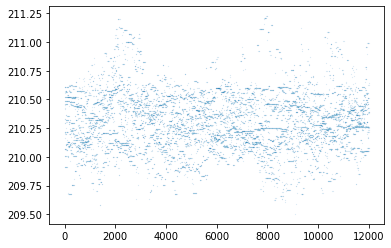

In [18]:
plt.plot(chain[:, 1], ".", markersize=0.1)

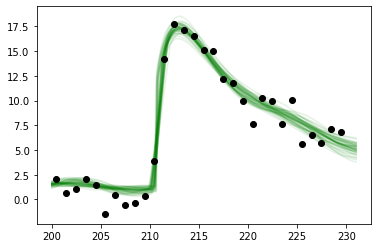

In [19]:
idx = np.random.randint(len(chain), size=50)
for i in idx:
    plt.plot(sf_recover.time_data_fine, sf_recover.dc14_fine(chain[i]), "g", alpha=0.1)
#     plt.plot(sf_recover.time_data, sf_recover.dc14(chain[i]), "g", alpha=0.3)

plt.plot(sf_recover.time_data + sf.time_offset, sf_recover.d14c_data, "ok")

In [21]:
params_truth = np.array([-2.20263609e-03,  210-205,  10**2.55367316e-01, 
                         10**8.21112436e-01/1.76, 3.28980240e+00, 10**-1.38787353e+00])

Text(0.5, 0.98, 'NH')

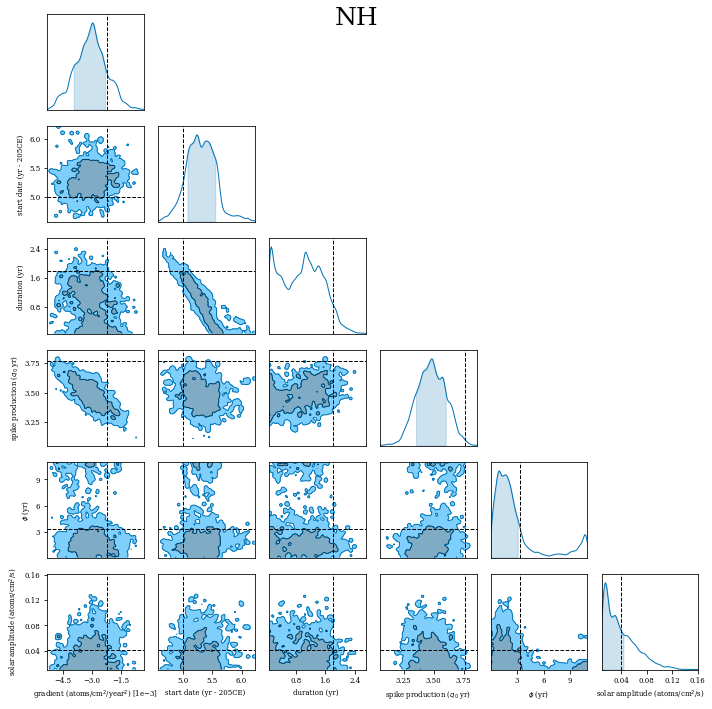

In [26]:
chain_copy = np.copy(chain)
start_date = "start date ({})".format("yr - " + str(int(210) - 5) + "CE")

chains = []
chains.append(chain_copy);

labels = ["gradient (atoms/cm$^2$/year$^2$)", start_date, "duration (yr)", "spike production ($q_0$ yr)", "$\phi$ (yr)", "solar amplitude (atoms/cm$^2$/s)"]
idx = 1
spike_idx  = 4
for i in range(len(chains)):
    chains[i][:, 2] = 10**chains[i][:, 2]
    chains[i][:, -1] = 10 ** chains[i][:, -1]
    chains[i][:, -2] = 10 ** chains[i][:, -2] / 1.76


for c in chains:
    c[:, idx] = c[:, idx] - (210 - 5)
    spike = c.copy()[:, spike_idx]
    c[:, spike_idx] = c[:, spike_idx - 1]
    c[:, spike_idx - 1] = spike

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
cf = fitting.CarbonFitter()
fig = cf.plot_multiple_chains(chains, chain.shape[1] * 2,
                        params_labels=labels,
                        label_font_size=7,
                        tick_font_size=7, colors=colors, max_ticks=4, legend=False, truth=params_truth
                        )

font = font_manager.FontProperties(family='serif', size=14)
# custom_lines = [Line2D([0], [0], color=colors[i], lw=0, label=["NH", "SH"][i]) for i in range(len(["NH", "SH"]))]
ax = fig.get_axes()[5]
# legend = ax.legend(handles=custom_lines, frameon=False, labelcolor=colors,
#                    prop=font, loc="upper right", bbox_to_anchor=(1, 0.5))
plt.suptitle("NH", fontsize=25)

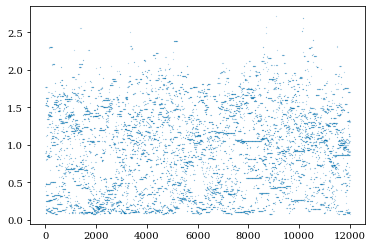

In [27]:
plt.plot(10**chain[:, 2], ".", markersize=0.2)

In [30]:
sf_recover.log_likelihood(np.mean(chain, axis=0))

DeviceArray(-20.00966914, dtype=float64)

In [29]:
sf_recover.log_likelihood(params)

DeviceArray(-33.58167554, dtype=float64)